In [1]:
import requests
import numpy as np
import pandas as pd
import pandas_profiling
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None

In [2]:
import statsmodels.api as sm # Provides cross-sectional models and methods
from statsmodels.graphics.api import abline_plot # Plots line given intercept and slope
from sklearn.metrics import mean_squared_error, r2_score # Rates how close regression line is to data
from sklearn.model_selection import train_test_split #  Splits data into training and test groups
from sklearn import linear_model, preprocessing # Ordinary least square regression and standardizes the data
import warnings # For handling error messages.

In [41]:
os.chdir(r'C:\Users\2bogu\Desktop\Sringboard_Materials\capstone2\data\interim')

df = pd.read_csv('iter_drop')

In [4]:
df.shape

(26863, 27)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26863 entries, 0 to 26862
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CONTRACT DATE             26863 non-null  object 
 1   SETUP DATE                26863 non-null  object 
 2   ORIGINAL LOAN AMOUNT      26863 non-null  float64
 3   ORIGINAL TERM             26863 non-null  int64  
 4   ORIGINAL MATURITY DATE    26863 non-null  object 
 5   CURRENT MATURITY DATE     26863 non-null  object 
 6   INTEREST RATE             26863 non-null  float64
 7   CREDIT SCORE              26863 non-null  float64
 8   CREDIT SCORE NAME 2       26863 non-null  float64
 9   DEBT TO INCOME            26863 non-null  float64
 10  PAYMENT AMOUNT            26863 non-null  float64
 11  CURRENT BALANCE           26863 non-null  float64
 12  UNAPPLIED CASH            26863 non-null  float64
 13  TOTAL INTEREST PAID       26863 non-null  float64
 14  TOTAL 

In [42]:
# removes unhelpful columns
df.drop(labels=['UNAPPLIED CASH', 'TOTAL LATE CHARGE PAID', 'Months Since Origination', 
                    'CURRENT BALANCE'], inplace=True, axis=1)

In [43]:
# gets avg credit score and removes two original columns
df['avg_credit_score'] = df[['CREDIT SCORE', 'CREDIT SCORE NAME 2']].mean(axis=1)
df.drop(['CREDIT SCORE', 'CREDIT SCORE NAME 2'], inplace=True, axis=1)

In [44]:
# CONVERTING TO DATETIOME OBJECTS
df['CONTRACT DATE'] = pd.to_datetime(df['CONTRACT DATE'], format="%m/%d/%Y")
df['SETUP DATE'] = pd.to_datetime(df['SETUP DATE'], format="%m/%d/%Y")
df['ORIGINAL MATURITY DATE'] = pd.to_datetime(df['ORIGINAL MATURITY DATE'], format="%m/%d/%Y")
df['CURRENT MATURITY DATE'] = pd.to_datetime(df['CURRENT MATURITY DATE'], format="%m/%d/%Y")
df['ACCOUNT CODE DATE'] = pd.to_datetime(df['ACCOUNT CODE DATE'], format="%m/%d/%Y")

In [45]:
# adds difference in original and current maturity date coulmn
# pos value means ahead, neg = behind
df['MATURITY DIFFERENCE'] = (df['ORIGINAL MATURITY DATE'] - df['CURRENT MATURITY DATE']).astype('timedelta64[M]')

In [46]:
# filters out loans less than a year old
df = df[(df['CONTRACT DATE'] < '09-01-2019')]

In [56]:
df.describe()

ORIGINAL LOAN AMOUNT  ORIGINAL TERM  INTEREST RATE  DEBT TO INCOME  \
count          25216.000000   25216.000000   25216.000000    25216.000000   
mean           11716.414142     168.805005       3.833215        0.317294   
std             6702.938282      31.273675       0.996243        0.180580   
min              701.000000      60.000000       2.990000        0.000000   
25%             6144.750000     180.000000       3.490000        0.190000   
50%            10519.500000     180.000000       3.490000        0.300000   
75%            16252.250000     180.000000       3.490000        0.430000   
max            25000.000000     180.000000       8.490000        1.000000   

       PAYMENT AMOUNT  TOTAL INTEREST PAID  Payments Made  avg_credit_score  \
count    25216.000000         25216.000000   25216.000000      25216.000000   
mean        92.227586          1403.095750      70.527399        735.227296   
std         53.332919          1018.428428      49.836022         53.518194   
min          5.000000           -99.000000       0.000000        512.000000   
25%         50.000000           571.000000      40.000000        700.000000   
50%         84.000000          1186.000000      55.000000        746.250000   
75%        128.000000          2058.250000      83.000000        779.500000   
max        455.000000          6317.000000     180.000000        833.000000   

       MATURITY DIFFERENCE  
count         25216.000000  
mean             22.302506  
std              52.406481  
min            -122.000000  
25%              -2.000000  
50%               0.000000  
75%               1.000000  
max             179.000000

In [55]:
df.drop(df['DEBT TO INCOME'].idxmax(), inplace=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25217 entries, 0 to 26862
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   CONTRACT DATE           25217 non-null  datetime64[ns]
 1   SETUP DATE              25217 non-null  datetime64[ns]
 2   ORIGINAL LOAN AMOUNT    25217 non-null  float64       
 3   ORIGINAL TERM           25217 non-null  int64         
 4   ORIGINAL MATURITY DATE  25217 non-null  datetime64[ns]
 5   CURRENT MATURITY DATE   25217 non-null  datetime64[ns]
 6   INTEREST RATE           25217 non-null  float64       
 7   DEBT TO INCOME          25217 non-null  float64       
 8   PAYMENT AMOUNT          25217 non-null  float64       
 9   TOTAL INTEREST PAID     25217 non-null  float64       
 10  SUCCESSOR NUMBER        25217 non-null  object        
 11  ACCOUNT CODE            25217 non-null  object        
 12  ACCOUNT CODE DATE       25217 non-null  dateti

In [47]:
# Converting num_borrowers into catagorical data to get dummies
df.num_borrowers = df.num_borrowers.astype(str)


In [60]:
# GETTING DUMMYS
df_dum = pd.get_dummies(df)

In [50]:
df_dum.head()

CONTRACT DATE SETUP DATE  ORIGINAL LOAN AMOUNT  ORIGINAL TERM  \
0    2016-10-12 2016-10-14                8563.0            180   
1    2015-11-25 2015-11-30               18351.0             60   
2    2015-01-15 2015-01-26               23330.0            180   
3    2015-10-28 2015-10-31               14263.0            180   
4    2017-06-02 2017-06-12               21646.0            180   

  ORIGINAL MATURITY DATE CURRENT MATURITY DATE  INTEREST RATE  DEBT TO INCOME  \
0             2031-10-12            2016-12-12           3.49            0.28   
1             2020-11-25            2016-07-25           3.49            0.19   
2             2030-01-15            2030-01-14           3.49            0.17   
3             2030-10-28            2019-07-08           3.49            0.38   
4             2032-06-02            2017-08-02           7.99            0.20   

   PAYMENT AMOUNT  TOTAL INTEREST PAID ACCOUNT CODE DATE  Payments Made  \
0            61.0                 51.0        2017-01-12          180.0   
1           334.0                404.0        2016-07-25           60.0   
2           167.0               3726.0        2015-01-26           64.0   
3           102.0               1307.0        2019-07-09          180.0   
4           207.0                412.0        2017-08-29          180.0   

   avg_credit_score  MATURITY DIFFERENCE  SUCCESSOR NUMBER_NONE  \
0             744.0                177.0                      1   
1             757.5                 52.0                      1   
2             785.5                  0.0                      1   
3             792.0                135.0                      1   
4             716.0                178.0                      1   

   SUCCESSOR NUMBER_S-0  SUCCESSOR NUMBER_s-0  ACCOUNT CODE_Canceled  \
0                     0                     0                      0   
1                     0                     0                      0   
2                     0                     0                      0   
3                     0                     0                      0   
4                     0                     0                      0   

   ACCOUNT CODE_Check/Money Order Payment (with coupon)  \
0                                                  0      
1                                                  0      
2                                                  0      
3                                                  0      
4                                                  0      

   ACCOUNT CODE_Collections Terminated (by customer)  \
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   

   ACCOUNT CODE_Legal Category  ACCOUNT CODE_Management Hold  \
0                            0                             0   
1                            0                             0   
2                            0                             0   
3                            0                             0   
4                            0                             0   

   ACCOUNT CODE_Notice of Bankruptcy (verbal)  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   ACCOUNT CODE_Notice of Bankruptcy (written)  ACCOUNT CODE_On Hold  \
0                                            0                     0   
1                                            0                     0   
2                                            0                     0   
3                                            0                     0   
4                                            0                     0   

   ACCOUNT CODE_Paid

In [61]:
# converts to floats
df = df.select_dtypes(include=['object', 'datetime']).join(df.select_dtypes(exclude=['object', 'datetime']).astype('float64')) 
df_dum = df_dum.select_dtypes(include=['object', 'datetime']).join(df_dum.select_dtypes(exclude=['object', 'datetime']).astype('float64'))

array([[<AxesSubplot:title={'center':'ORIGINAL LOAN AMOUNT'}>,
        <AxesSubplot:title={'center':'ORIGINAL TERM'}>,
        <AxesSubplot:title={'center':'INTEREST RATE'}>],
       [<AxesSubplot:title={'center':'DEBT TO INCOME'}>,
        <AxesSubplot:title={'center':'PAYMENT AMOUNT'}>,
        <AxesSubplot:title={'center':'TOTAL INTEREST PAID'}>],
       [<AxesSubplot:title={'center':'Payments Made'}>,
        <AxesSubplot:title={'center':'avg_credit_score'}>,
        <AxesSubplot:title={'center':'MATURITY DIFFERENCE'}>]],
      dtype=object)

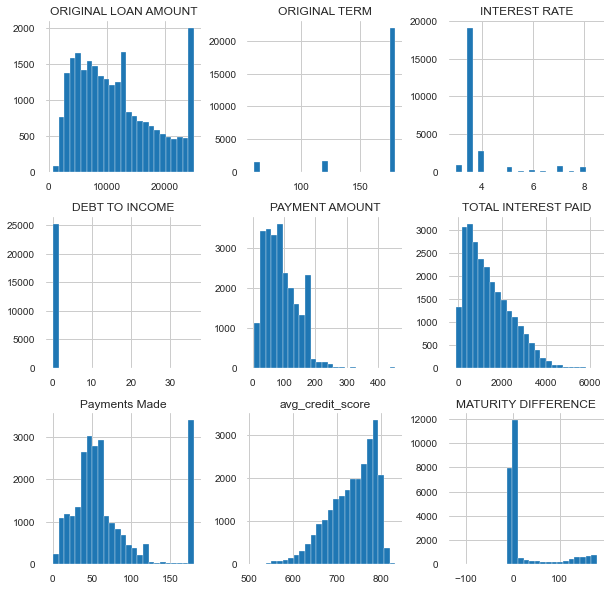

In [53]:
df.select_dtypes(exclude='object').hist(bins=25, figsize=(10,10))

C:\Users\2bogu\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\2bogu\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\2bogu\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\2bogu\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\2bogu\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\2bogu\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Defa

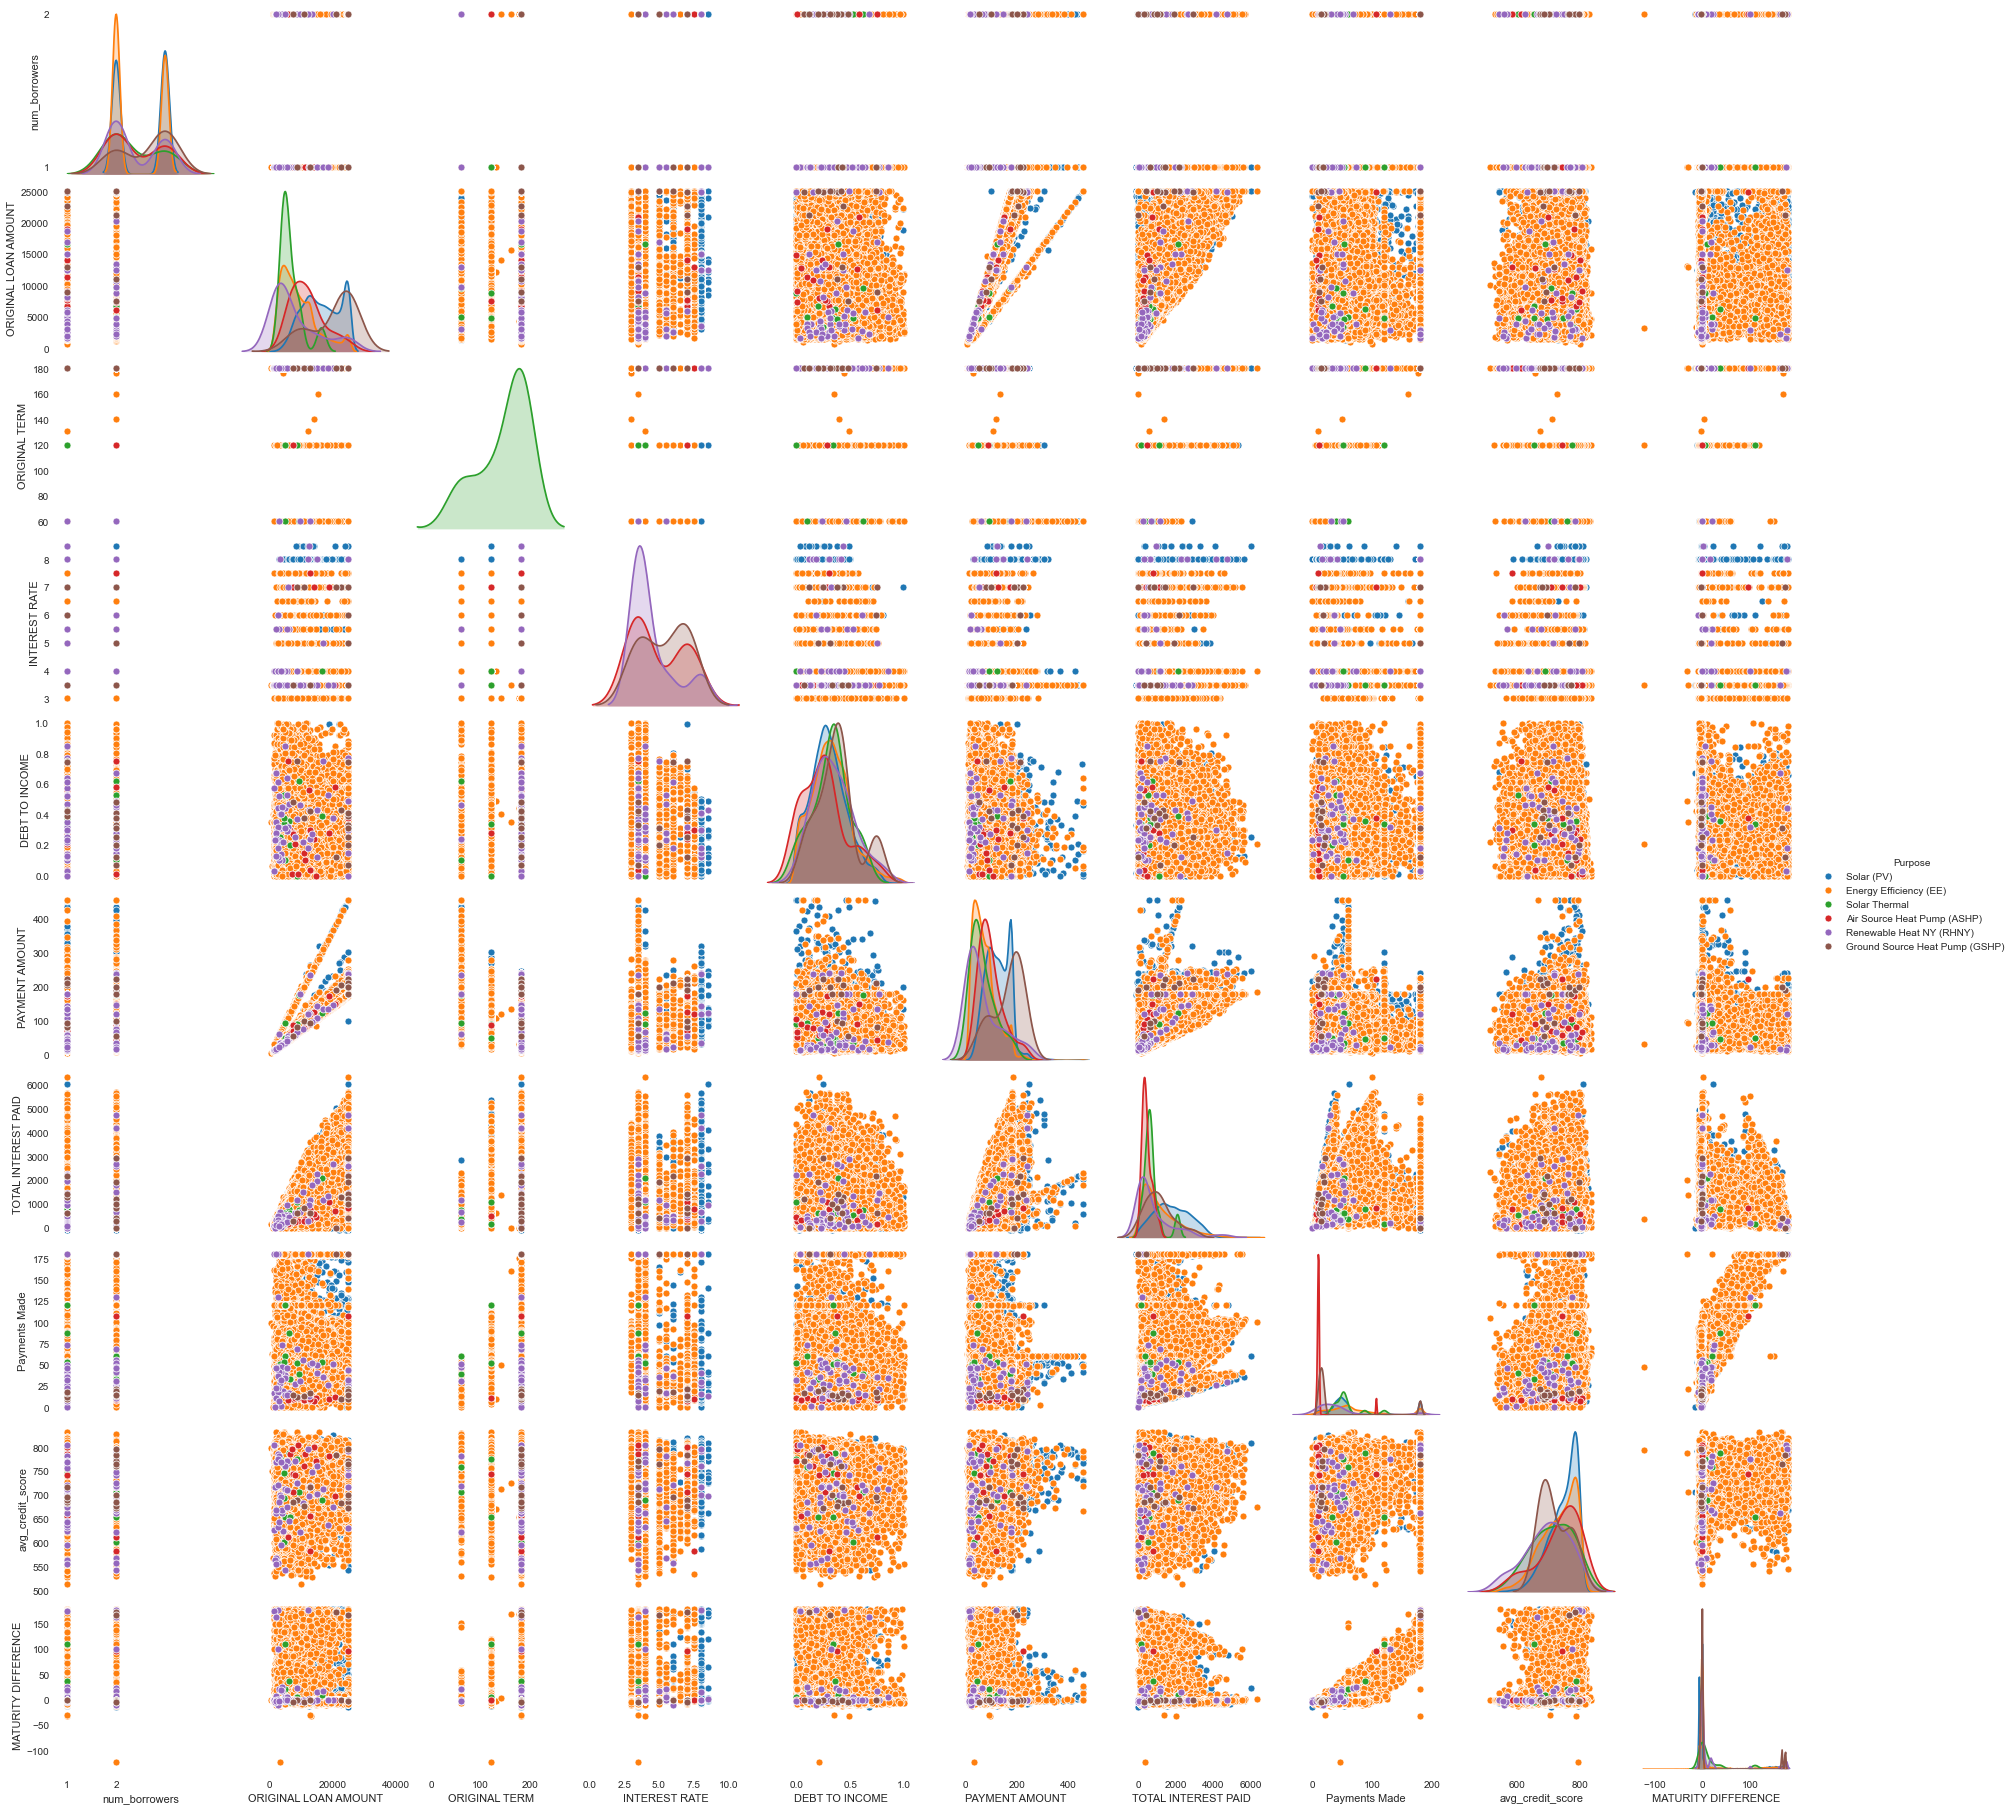

In [57]:
sns.pairplot(df, hue='Purpose')

C:\Users\2bogu\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\2bogu\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\2bogu\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


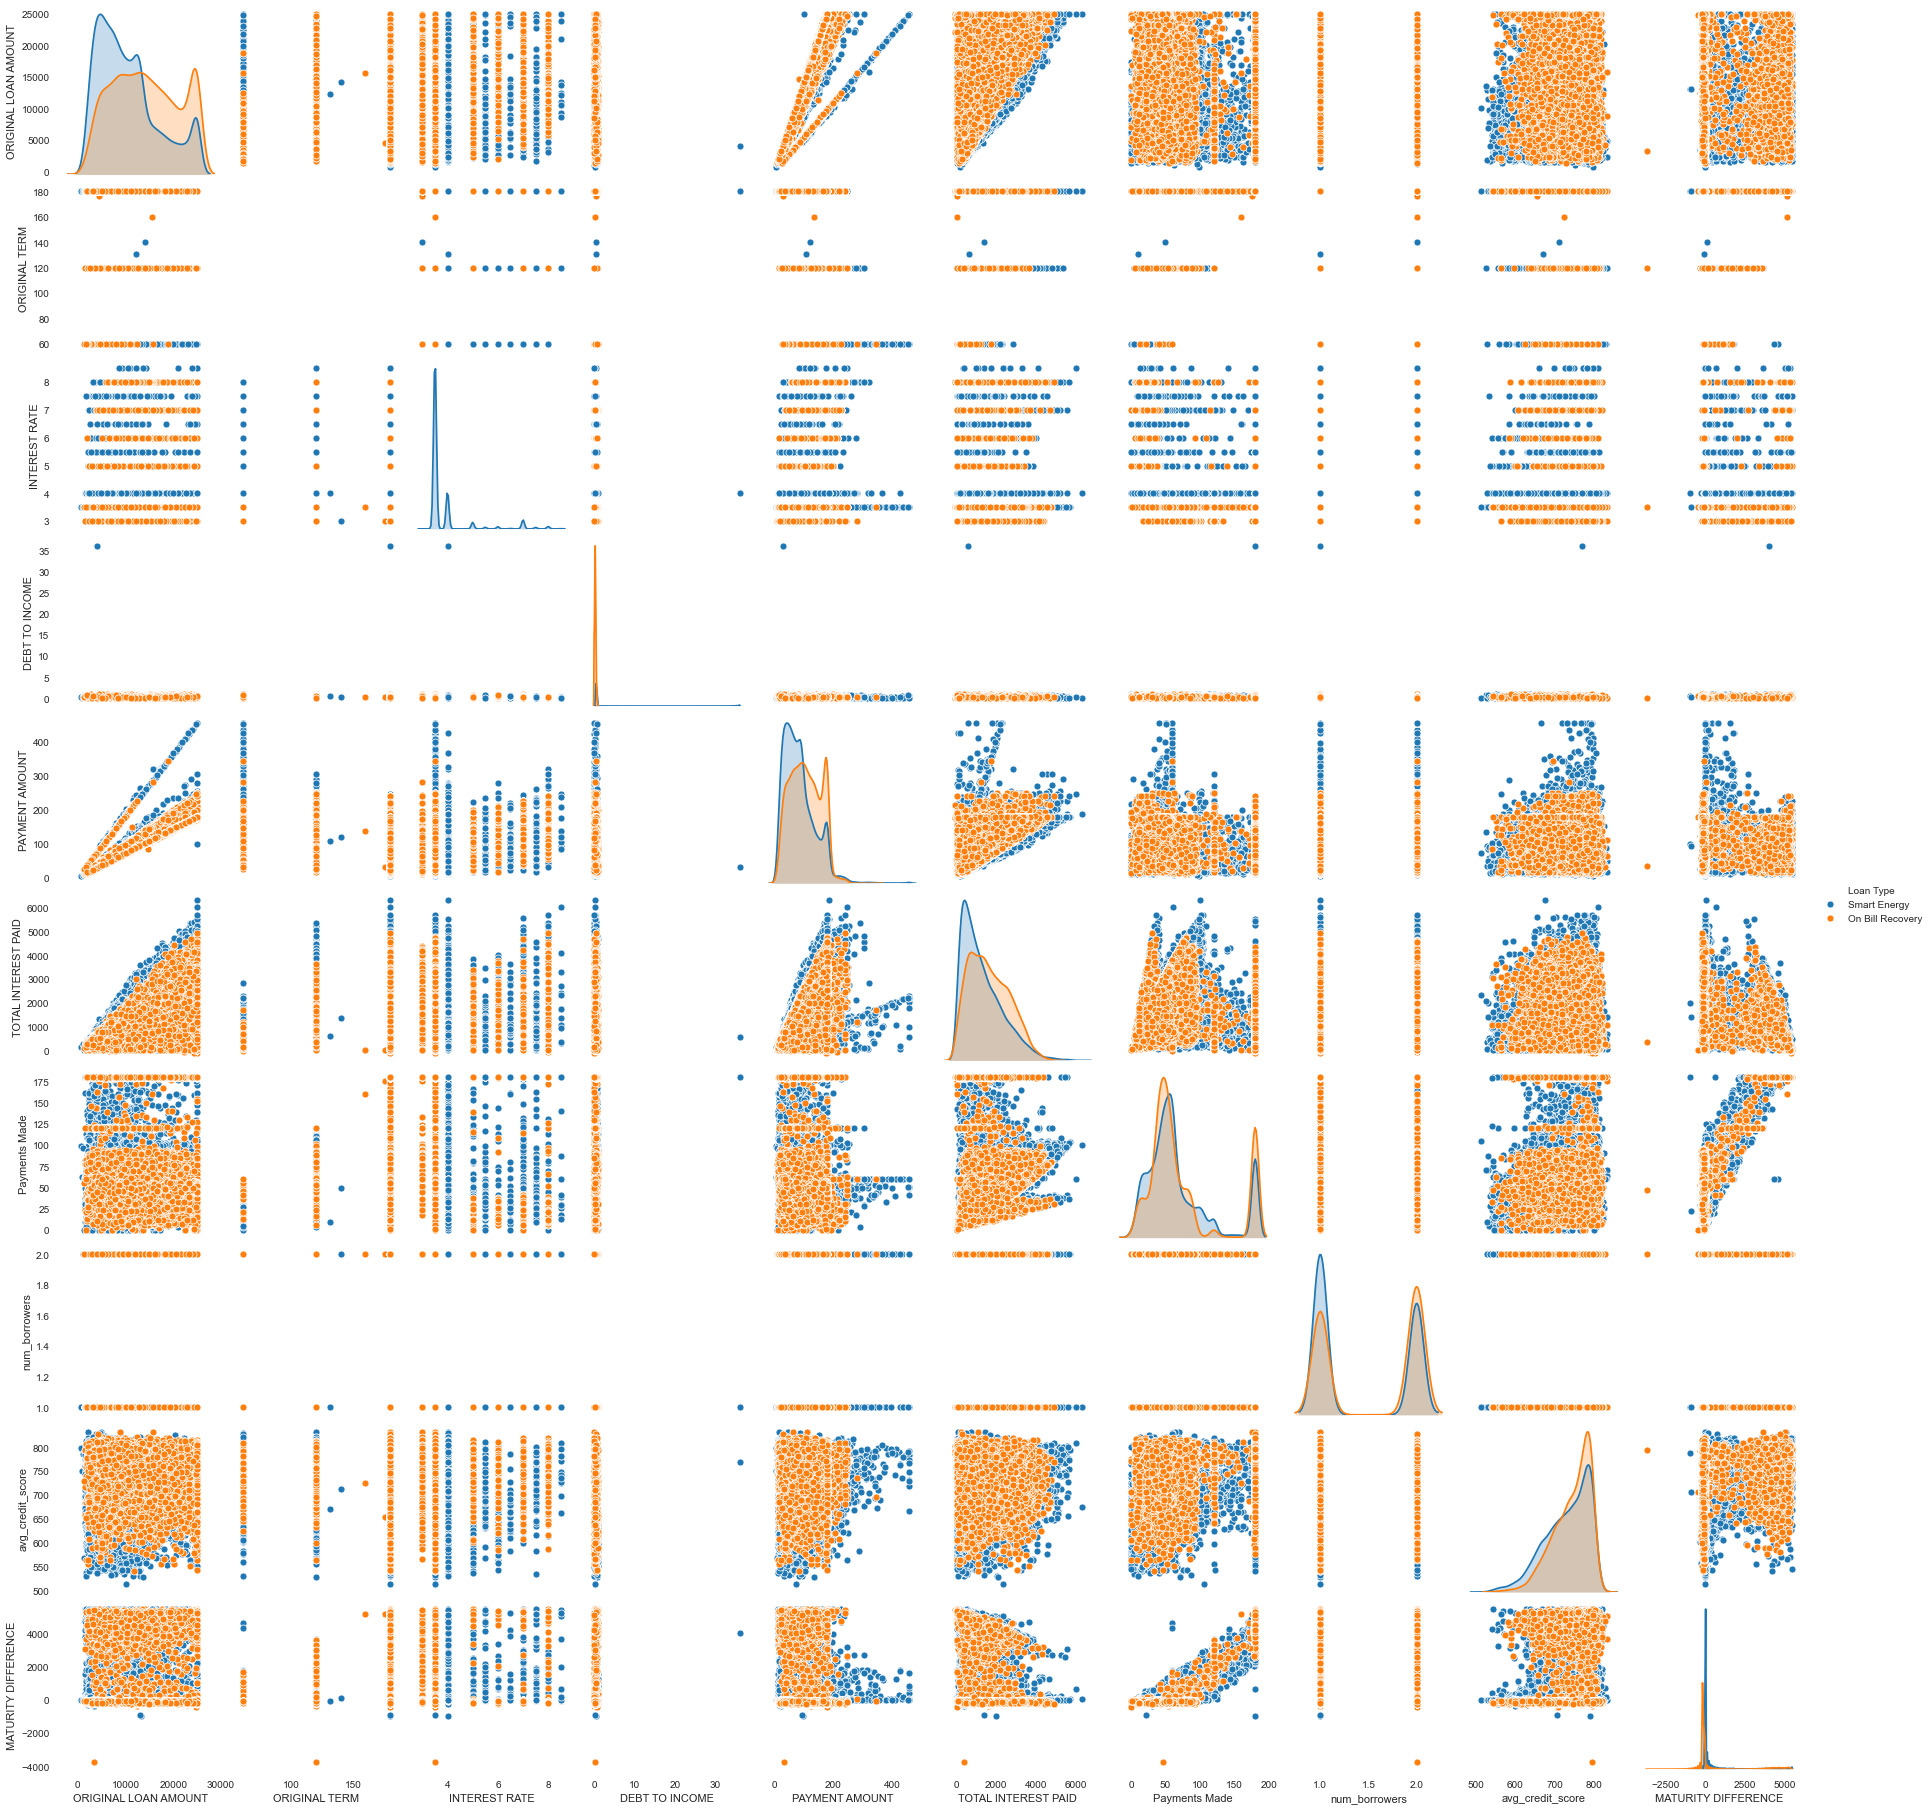

In [36]:
sns.pairplot(df, hue='Loan Type')

<AxesSubplot:>

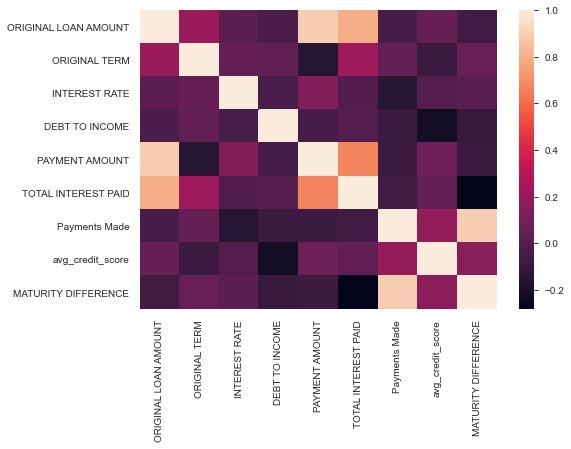

In [71]:
sns.heatmap(df.corr())

In [65]:
df_dum.corr()

ORIGINAL LOAN AMOUNT  \
ORIGINAL LOAN AMOUNT                                            1.000000   
ORIGINAL TERM                                                   0.212976   
INTEREST RATE                                                   0.027749   
DEBT TO INCOME                                                 -0.024218   
PAYMENT AMOUNT                                                  0.895683   
TOTAL INTEREST PAID                                             0.795528   
Payments Made                                                  -0.040410   
avg_credit_score                                                0.057129   
MATURITY DIFFERENCE                                            -0.057787   
SUCCESSOR NUMBER_NONE                                          -0.016019   
SUCCESSOR NUMBER_S-0                                            0.016317   
SUCCESSOR NUMBER_s-0                                           -0.004863   
ACCOUNT CODE_Canceled                                          -0.025532   
ACCOUNT CODE_Check/Money Order Payment (with co...              0.168511   
ACCOUNT CODE_Collections Terminated (by customer)               0.008588   
ACCOUNT CODE_Legal Category                                    -0.030233   
ACCOUNT CODE_Management Hold                                    0.000021   
ACCOUNT CODE_Notice of Bankruptcy (verbal)                     -0.001809   
ACCOUNT CODE_Notice of Bankruptcy (written)                    -0.028458   
ACCOUNT CODE_On Hold                                           -0.019537   
ACCOUNT CODE_Paid in Full                                      -0.108086   
ACCOUNT CODE_Soft Hold                                         -0.016536   
ACCOUNT CODE_SurePay/Automatic Debit Payment                   -0.057069   
ACCOUNT CODE_SurePay/Automatic Debit Payment (o...             -0.001495   
CANCEL REASON_CANCEL DUE TO BANKRUPTCY                          0.000524   
CANCEL REASON_CUSTOMER DEFAULTED                                0.009849   
CANCEL REASON_DEATH                                            -0.032178   
CANCEL REASON_INVOLUNTARY REPOSESSION                           0.007861   
CANCEL REASON_NONE                                              0.025532   
CANCEL REASON_SETTLEMENT                                       -0.012939   
CANCEL REASON_VOLUNTARY REPOSESSION                            -0.002313   
TYPE OF BANKRUPTCY_Chapter 13 Bankruptcy                       -0.002925   
TYPE OF BANKRUPTCY_Chapter 7 Bankruptcy                        -0.023648   
TYPE OF BANKRUPTCY_NONE                                         0.022391   
Purpose_Air Source Heat Pump (ASHP)                             0.001754   
Purpose_Energy Efficiency (EE)                                 -0.497653   
Purpose_Ground Source Heat Pump (GSHP)                          0.030091   
Purpose_Renewable Heat NY (RHNY)                               -0.023068   
Purpose_Solar (PV)                                              0.500561   
Purpose_Solar Thermal                                          -0.015111   
Loan Type_On Bill Recovery                                      0.261949   
Loan Type_Smart Energy                                         -0.261949   
Underwriting_Tier 1                                             0.060274   
Underwriting_Tier 2                                            -0.060274   
Pledged_Series 2013A EE Bonds                                  -0.119154   
Pledged_Series 2015A EE Bonds                                  -0.101090   
Pledged_Series 2015A PV Bonds                                   0.352430   
Pledged_Series 2016A EE Bonds                                  -0.144650   
Pledged_Series 2018A PV Bonds                                   0.173086   
Pledged_Series 2019A EE & PV Bonds                             -0.074645   
Pledged_Unpledged                                              -0.060353   
num_borrowers_1                                                -0.167781   
num_borrowers_2         

<AxesSubplot:>

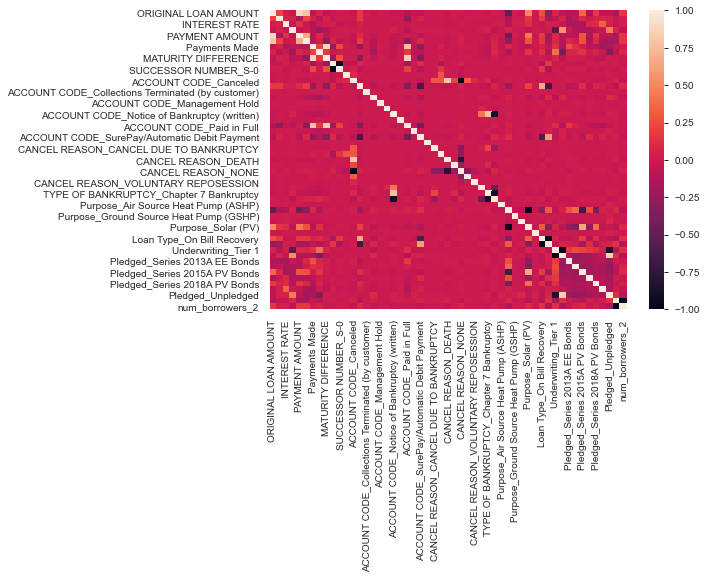

In [72]:
sns.heatmap(df_dum.corr())

<AxesSubplot:>

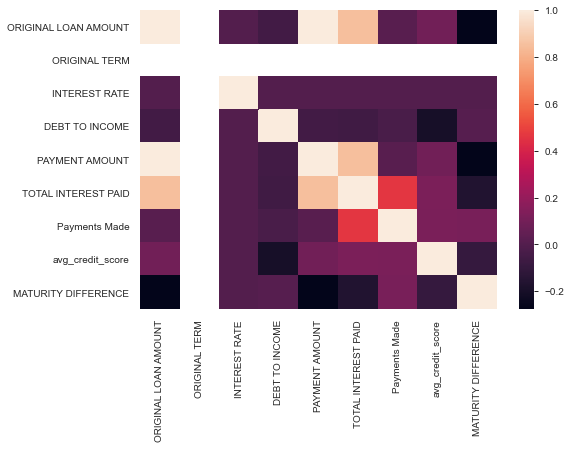

In [67]:
sns.heatmap(dfno.corr())

<AxesSubplot:xlabel='Payments Made', ylabel='MATURITY DIFFERENCE'>

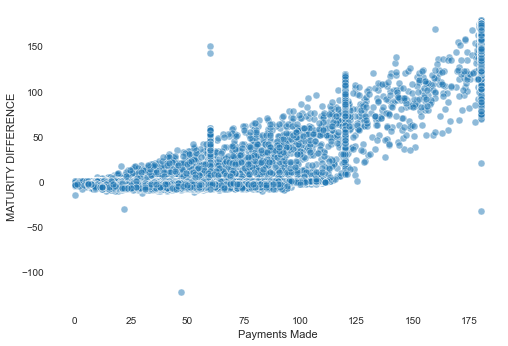

In [70]:
sns.scatterplot(x='Payments Made', y='MATURITY DIFFERENCE', data=df, alpha=0.5)

<AxesSubplot:xlabel='Payments Made', ylabel='MATURITY DIFFERENCE'>

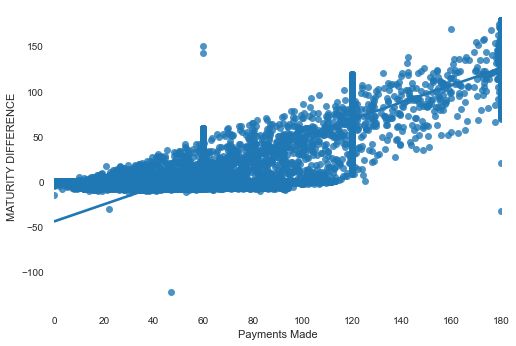

In [73]:
sns.regplot(x='Payments Made', y='MATURITY DIFFERENCE', data=df)

In [74]:
# model with only one independent variable w/o dummies
y = df[['MATURITY DIFFERENCE']]
X = df[['Payments Made']]

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

ols_model1 = sm.OLS(y_train, X_train)

ols_fit1 = ols_model1.fit()

ols_fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     MATURITY DIFFERENCE   R-squared:                       0.801
Model:                             OLS   Adj. R-squared:                  0.801
Method:                  Least Squares   F-statistic:                 7.607e+04
Date:                 Tue, 15 Sep 2020   Prob (F-statistic):               0.00
Time:                         12:07:07   Log-Likelihood:                -86391.
No. Observations:                18912   AIC:                         1.728e+05
Df Residuals:                    18910   BIC:                         1.728e+05
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -44.1657      0.294   -150.090      0.000     -44.742     -43.589
Payments Made     0.9420      0.003    275.815      0.000       0.935       0.949
==============================================================================
Omnibus:                       41.105   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.279
Skew:                          -0.112   Prob(JB):                     1.09e-09
Kurtosis:                       2.949   Cond. No.                         150.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

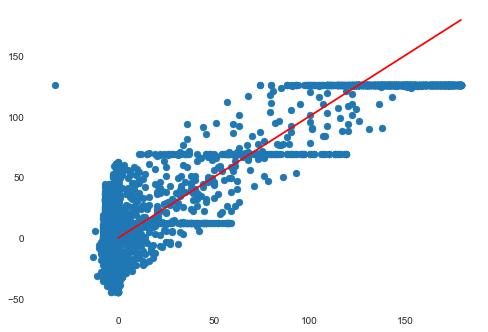

In [79]:
y_pred = ols_fit1.predict(X_test)

_ = plt.scatter(y_test, y_pred)

_ = plt.plot([x for x in range(0,180)],[x for x in range(0,180)], color='red')

plt.show()

In [80]:
df_dum.corr()

ORIGINAL LOAN AMOUNT  \
ORIGINAL LOAN AMOUNT                                            1.000000   
ORIGINAL TERM                                                   0.212976   
INTEREST RATE                                                   0.027749   
DEBT TO INCOME                                                 -0.024218   
PAYMENT AMOUNT                                                  0.895683   
TOTAL INTEREST PAID                                             0.795528   
Payments Made                                                  -0.040410   
avg_credit_score                                                0.057129   
MATURITY DIFFERENCE                                            -0.057787   
SUCCESSOR NUMBER_NONE                                          -0.016019   
SUCCESSOR NUMBER_S-0                                            0.016317   
SUCCESSOR NUMBER_s-0                                           -0.004863   
ACCOUNT CODE_Canceled                                          -0.025532   
ACCOUNT CODE_Check/Money Order Payment (with co...              0.168511   
ACCOUNT CODE_Collections Terminated (by customer)               0.008588   
ACCOUNT CODE_Legal Category                                    -0.030233   
ACCOUNT CODE_Management Hold                                    0.000021   
ACCOUNT CODE_Notice of Bankruptcy (verbal)                     -0.001809   
ACCOUNT CODE_Notice of Bankruptcy (written)                    -0.028458   
ACCOUNT CODE_On Hold                                           -0.019537   
ACCOUNT CODE_Paid in Full                                      -0.108086   
ACCOUNT CODE_Soft Hold                                         -0.016536   
ACCOUNT CODE_SurePay/Automatic Debit Payment                   -0.057069   
ACCOUNT CODE_SurePay/Automatic Debit Payment (o...             -0.001495   
CANCEL REASON_CANCEL DUE TO BANKRUPTCY                          0.000524   
CANCEL REASON_CUSTOMER DEFAULTED                                0.009849   
CANCEL REASON_DEATH                                            -0.032178   
CANCEL REASON_INVOLUNTARY REPOSESSION                           0.007861   
CANCEL REASON_NONE                                              0.025532   
CANCEL REASON_SETTLEMENT                                       -0.012939   
CANCEL REASON_VOLUNTARY REPOSESSION                            -0.002313   
TYPE OF BANKRUPTCY_Chapter 13 Bankruptcy                       -0.002925   
TYPE OF BANKRUPTCY_Chapter 7 Bankruptcy                        -0.023648   
TYPE OF BANKRUPTCY_NONE                                         0.022391   
Purpose_Air Source Heat Pump (ASHP)                             0.001754   
Purpose_Energy Efficiency (EE)                                 -0.497653   
Purpose_Ground Source Heat Pump (GSHP)                          0.030091   
Purpose_Renewable Heat NY (RHNY)                               -0.023068   
Purpose_Solar (PV)                                              0.500561   
Purpose_Solar Thermal                                          -0.015111   
Loan Type_On Bill Recovery                                      0.261949   
Loan Type_Smart Energy                                         -0.261949   
Underwriting_Tier 1                                             0.060274   
Underwriting_Tier 2                                            -0.060274   
Pledged_Series 2013A EE Bonds                                  -0.119154   
Pledged_Series 2015A EE Bonds                                  -0.101090   
Pledged_Series 2015A PV Bonds                                   0.352430   
Pledged_Series 2016A EE Bonds                                  -0.144650   
Pledged_Series 2018A PV Bonds                                   0.173086   
Pledged_Series 2019A EE & PV Bonds                             -0.074645   
Pledged_Unpledged                                              -0.060353   
num_borrowers_1                                                -0.167781   
num_borrowers_2         

<AxesSubplot:xlabel='ACCOUNT CODE_Paid in Full', ylabel='MATURITY DIFFERENCE'>

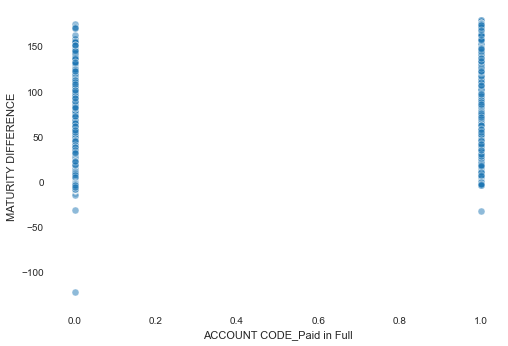

In [84]:
# i don't know what i expected
sns.scatterplot(x='ACCOUNT CODE_Paid in Full', y='MATURITY DIFFERENCE', data=df_dum, alpha=0.5)

In [97]:
# model with one independent var w/ dummies
y = df_dum[['MATURITY DIFFERENCE']]
X = df_dum[['ACCOUNT CODE_Paid in Full']]

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

ols_model3 = sm.OLS(y_train, X_train)

ols_fit3 = ols_model3.fit()

ols_fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     MATURITY DIFFERENCE   R-squared:                       0.687
Model:                             OLS   Adj. R-squared:                  0.687
Method:                  Least Squares   F-statistic:                 4.142e+04
Date:                 Tue, 15 Sep 2020   Prob (F-statistic):               0.00
Time:                         12:35:50   Log-Likelihood:                -90683.
No. Observations:                18912   AIC:                         1.814e+05
Df Residuals:                    18910   BIC:                         1.814e+05
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         1.3497      0.236      5.717      0.000       0.887       1.812
ACCOUNT CODE_Paid in Full   110.8544      0.545    203.512      0.000     109.787     111.922
==============================================================================
Omnibus:                     3449.089   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35646.211
Skew:                          -0.573   Prob(JB):                         0.00
Kurtosis:                       9.627   Cond. No.                         2.67
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

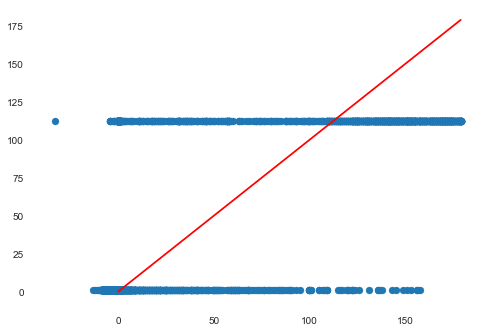

In [98]:
y_pred = ols_fit3.predict(X_test)

_ = plt.scatter(y_test, y_pred)

_ = plt.plot([x for x in range(0,180)],[x for x in range(0,180)], color='red')

plt.show()

In [104]:
# model with all independents possible w/o dummies
y = df_dum[['MATURITY DIFFERENCE']]
X = df_dum.select_dtypes(include=['float64']).drop('MATURITY DIFFERENCE', axis=1)



X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

ols_model4 = sm.OLS(y_train, X_train)

ols_fit4 = ols_model4.fit()

ols_fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     MATURITY DIFFERENCE   R-squared:                       0.968
Model:                             OLS   Adj. R-squared:                  0.968
Method:                  Least Squares   F-statistic:                 1.403e+04
Date:                 Tue, 15 Sep 2020   Prob (F-statistic):               0.00
Time:                         14:08:04   Log-Likelihood:                -69058.
No. Observations:                18912   AIC:                         1.382e+05
Df Residuals:                    18870   BIC:                         1.385e+05
Df Model:                           41                                         
Covariance Type:             nonrobust                                         
==========================================================================================================================
                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
const                                                    -16.2903      0.525    -31.058      0.000     -17.318     -15.262
ORIGINAL LOAN AMOUNT                                       0.0025   4.83e-05     51.341      0.000       0.002       0.003
ORIGINAL TERM                                              0.0970      0.004     22.824      0.000       0.089       0.105
INTEREST RATE                                              4.5606      0.091     50.334      0.000       4.383       4.738
DEBT TO INCOME                                            -2.9567      0.457     -6.474      0.000      -3.852      -2.061
PAYMENT AMOUNT                                            -0.0717      0.005    -13.526      0.000      -0.082      -0.061
TOTAL INTEREST PAID                                       -0.0169      0.000   -108.555      0.000      -0.017      -0.017
Payments Made                                              0.8171      0.003    289.409      0.000       0.812       0.823
avg_credit_score                                           0.0006      0.001      0.448      0.654      -0.002       0.003
SUCCESSOR NUMBER_NONE                                    -11.7175      0.392    -29.886      0.000     -12.486     -10.949
SUCCESSOR NUMBER_S-0                                      -4.5728      0.431    -10.612      0.000      -5.417      -3.728
SUCCESSOR NUMBER_s-0                                    7.393e-14   1.84e-14      4.009      0.000    3.78e-14     1.1e-13
ACCOUNT CODE_Canceled                                     -5.7014      1.154     -4.942      0.000      -7.963      -3.440
ACCOUNT CODE_Check/Money Order Payment (with coupon)     -11.0327      1.416     -7.790      0.000     -13.809      -8.257
ACCOUNT CODE_Collections Terminated (by customer)          9.6219      8.609      1.118      0.264      -7.253      26.497
ACCOUNT CODE_Legal Category                               -2.5261      1.500     -1.684      0.092      -5.466       0.413
ACCOUNT CODE_Management Hold                              14.0653      6.175      2.278      0.023       1.962      26.169
ACCOUNT CODE_Notice of Bankruptcy (verbal)               -11.7657      5.099     -2.307      0.021     -21.761      -1.771
ACCOUNT CODE_Notice of Bankruptcy (written)                0.0041      2.237      0.002      0.999      -4.380       4.388
ACCOUNT CODE_On Hold                                      -0.1531      2.828     -0.054      0.957      -5.696       5.390
ACCOUNT CODE_Paid in Full                                 18.4082      1.434     12.838      0.000      15.598      21.219
ACCOUNT CODE_Soft Hold                                    -5.3757      1.834     -2.931      0.003      -8.971      -1.7

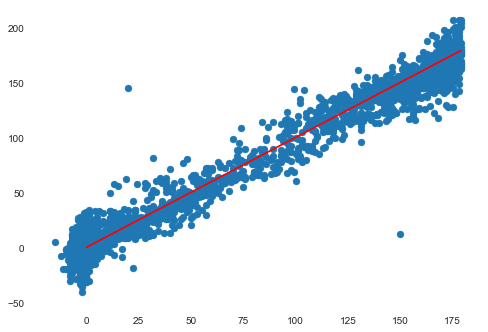

In [105]:
y_pred = ols_fit4.predict(X_test)

_ = plt.scatter(y_test, y_pred)

_ = plt.plot([x for x in range(0,180)],[x for x in range(0,180)], color='red')

plt.show()

In [107]:
# model with all possible independents w/ dummies

y = df[['MATURITY DIFFERENCE']]
X = df.select_dtypes(include=['float64']).drop('MATURITY DIFFERENCE', axis=1)



X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

ols_model5 = sm.OLS(y_train, X_train)

ols_fit5 = ols_model5.fit()

ols_fit5.summary()
# what to do with p>0.05 from dummy var where other dummy vars from same feature have P<0.05

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     MATURITY DIFFERENCE   R-squared:                       0.937
Model:                             OLS   Adj. R-squared:                  0.937
Method:                  Least Squares   F-statistic:                 3.536e+04
Date:                 Tue, 15 Sep 2020   Prob (F-statistic):               0.00
Time:                         14:11:22   Log-Likelihood:                -75481.
No. Observations:                18912   AIC:                         1.510e+05
Df Residuals:                    18903   BIC:                         1.511e+05
Df Model:                            8                                         
Covariance Type:             nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -64.6963      1.680    -38.512      0.000     -67.989     -61.404
ORIGINAL LOAN AMOUNT     0.0036   6.34e-05     57.446      0.000       0.004       0.004
ORIGINAL TERM            0.0381      0.006      6.855      0.000       0.027       0.049
INTEREST RATE            7.2893      0.110     66.187      0.000       7.073       7.505
DEBT TO INCOME          -2.8308      0.543     -5.210      0.000      -3.896      -1.766
PAYMENT AMOUNT          -0.0623      0.007     -8.416      0.000      -0.077      -0.048
TOTAL INTEREST PAID     -0.0285      0.000   -181.770      0.000      -0.029      -0.028
Payments Made            0.9405      0.002    471.912      0.000       0.937       0.944
avg_credit_score        -0.0133      0.002     -7.122      0.000      -0.017      -0.010
==============================================================================
Omnibus:                     1897.893   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8953.688
Skew:                          -0.389   Prob(JB):                         0.00
Kurtosis:                       6.280   Cond. No.                     2.41e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.41e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

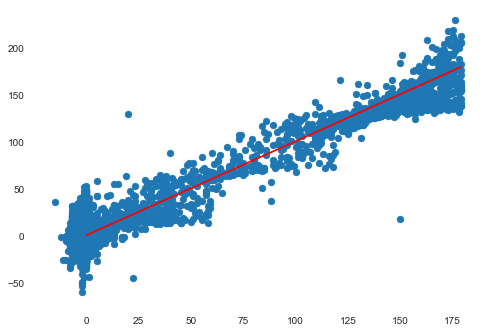

In [108]:
y_pred = ols_fit5.predict(X_test)

_ = plt.scatter(y_test, y_pred)

_ = plt.plot([x for x in range(0,180)],[x for x in range(0,180)], color='red')

plt.show()